# EYE FOR BLIND
This notebook will be used to prepare the capstone project 'Eye for Blind'

In [1]:
#Import all the required libraries

import os,glob

import pickle
from sys import getsizeof



import numpy as np 
import pandas as pd
pd.set_option('display.max_colwidth',-1)

from skimage import io
from PIL import Image
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import collections, random, re      # This module implements specialized container datatypes providing alternatives to Python’s general purpose built-in containers, dict, list, set, and tuple.
from collections import Counter



from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle


import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras import layers,Model 
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import plot_model

import operator

from tqdm import tqdm


Populating the interactive namespace from numpy and matplotlib


Let's read the dataset

## Data understanding
1.Import the dataset and read image & captions into two seperate variables

2.Visualise both the images & text present in the dataset

3.Create word-to-index and index-to-word mappings.

4.Create a dataframe which summarizes the image, path & captions as a dataframe

5.Visualise the top 30 occuring words in the captions

6.Create a list which contains all the captions & path


In [2]:
input_path='./Flickr8K/'
image_path=input_path+'Images/'
caption_text_file=input_path+'captions.txt'
output_images='./Images/'

In [3]:
#Import the dataset and read the image into a seperate variable

images=image_path

all_imgs = glob.glob(images + '/*.jpg',recursive=True)
print("The total images present in the dataset: {}".format(len(all_imgs)))

The total images present in the dataset: 8091


In [4]:
## Let's check the variable all_imgs

all_imgs[0]

'./Flickr8K/Images/2201222219_8d656b0633.jpg'

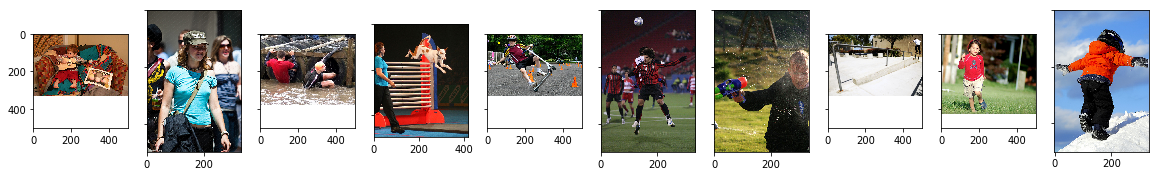

In [5]:
#Visualise both the images & text present in the dataset

def show_image(images):
    size, axes= plt.subplots(1, len(images),sharey=True)
    size.set_figwidth(20) 
    

    for ax,imageUrl in zip(axes,images):
        ax.imshow(io.imread(imageUrl), None)



show_image(all_imgs[:10])

    ~ Seems like All the image sizes are irregular

In [6]:
captions=pd.read_csv(caption_text_file)
captions.shape

(40455, 2)

In [7]:
captions.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .


In [8]:
captions.nunique()

image      8091 
caption    40201
dtype: int64

    ~ For average there are 4-5 captions per image

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .


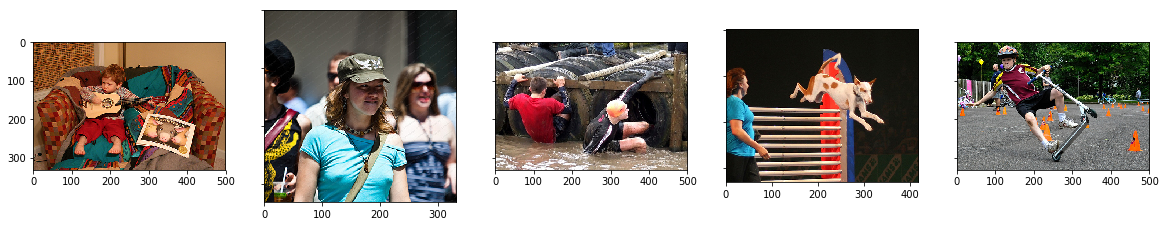

In [9]:
## Checking Images with captions 
show_image(all_imgs[:5])
captions.head(5)

In [10]:
#Import the dataset and read the text file into a seperate variable

def load_doc(filename):
    
    #your code here
    selected_file=open(filename,'r')
    captions_txt=selected_file.read().splitlines()
    captions_txt.pop(0)
    selected_file.close()
    return captions_txt

doc = load_doc(caption_text_file)
print(doc[:300])

['1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .', '1000268201_693b08cb0e.jpg,A girl going into a wooden building .', '1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .', '1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .', '1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .', '1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting', '1001773457_577c3a7d70.jpg,A black dog and a tri-colored dog playing with each other on the road .', '1001773457_577c3a7d70.jpg,A black dog and a white dog with brown spots are staring at each other in the street .', '1001773457_577c3a7d70.jpg,Two dogs of different breeds looking at each other on the road .', '1001773457_577c3a7d70.jpg,Two dogs on pavement moving toward each other .', '1002674143_1b742ab4b8.jpg,A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .', '

In [11]:
## Creating datframe to summarize with extra vectors
temp_dataFrame=pd.DataFrame({'ID':[],'Path':[],'Captions':[]})
temp_dataFrame[['ID']]=captions.image.apply(lambda x:pd.Series(str(x).split("_")[0]))
temp_dataFrame[['Path']]=captions.image.apply(lambda x:pd.Series(image_path+str(x)))
temp_dataFrame[['Captions']]=captions.caption
temp_dataFrame.head()


,ID,Path,Captions
0,1000268201,./Flickr8K/Images/1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1,1000268201,./Flickr8K/Images/1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201,./Flickr8K/Images/1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201,./Flickr8K/Images/1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .
4,1000268201,./Flickr8K/Images/1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .


Create a dataframe which summarizes the image, path & captions as a dataframe

Each image id has 5 captions associated with it therefore the total dataset should have 40455 samples.

In [12]:
all_img_id= temp_dataFrame['ID']
all_img_vector= temp_dataFrame['Path']
annotations= temp_dataFrame['Captions']

df = pd.DataFrame(list(zip(all_img_id, all_img_vector,annotations)),columns =['ID','Path', 'Captions']) 
    
df

,ID,Path,Captions
0,1000268201,./Flickr8K/Images/1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1,1000268201,./Flickr8K/Images/1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201,./Flickr8K/Images/1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201,./Flickr8K/Images/1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .
4,1000268201,./Flickr8K/Images/1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .
5,1001773457,./Flickr8K/Images/1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting
6,1001773457,./Flickr8K/Images/1001773457_577c3a7d70.jpg,A black dog and a tri-colored dog playing with each other on the road .
7,1001773457,./Flickr8K/Images/1001773457_577c3a7d70.jpg,A black dog and a white dog with brown spots are staring at each other in the street .
8,1001773457,./Flickr8K/Images/1001773457_577c3a7d70.jpg,Two dogs of different breeds looking at each other on the road .
9,1001773457,./Flickr8K/Images/1001773457_577c3a7d70.jpg,Two dogs on pavement moving toward each other .


In [13]:
del temp_dataFrame    # deleting temp_dataframe variable to avoid un-neccessary memory occupation

In [14]:
#Create the vocabulary & the counter for the captions

def splitting_sentence(sentence):
    return list(filter(lambda x: len(x) > 0, re.split('\W+', sentence.lower())))

def generate_list_of_words(caption_column):
    vocabulary_list=[]
    for x in caption_column:
        splitted_words=splitting_sentence(x)
        for words in splitted_words:
            vocabulary_list.append(words)
    return sorted(vocabulary_list) 

vocabulary= generate_list_of_words(df['Captions'])

val_count=Counter(vocabulary)
val_count

Counter({'08': 1,
         '1': 2,
         '10': 1,
         '104': 2,
         '11': 2,
         '12': 4,
         '13': 4,
         '13406': 1,
         '157': 1,
         '17': 1,
         '19': 3,
         '1915': 1,
         '1923': 1,
         '1950s': 1,
         '2': 24,
         '2008': 1,
         '21': 2,
         '22': 1,
         '23': 5,
         '25': 3,
         '28': 3,
         '281': 2,
         '29': 1,
         '3': 18,
         '30': 1,
         '32': 1,
         '33': 1,
         '3rd': 2,
         '4': 20,
         '42': 1,
         '4x4': 1,
         '5': 19,
         '50': 1,
         '52': 2,
         '528': 1,
         '57': 1,
         '58': 2,
         '6': 9,
         '625': 1,
         '661': 1,
         '7': 3,
         '75': 1,
         '8': 17,
         '80': 1,
         '84': 2,
         '90': 1,
         '93': 1,
         '97': 1,
         'a': 62992,
         'abandon': 2,
         'abandoned': 5,
         'abarrotes': 1,
         'abdomen': 1,
  

In [15]:
# Number of occuring words 

word_count = pd.DataFrame.from_dict(val_count, orient='index')
word_count = word_count.sort_values(by=[0],ascending=False).reset_index()
word_count =word_count.rename(columns={'index':'Word', 0:'Count'})
word_count.head()

,Word,Count
0,a,62992
1,in,18986
2,the,18419
3,on,10745
4,is,9345


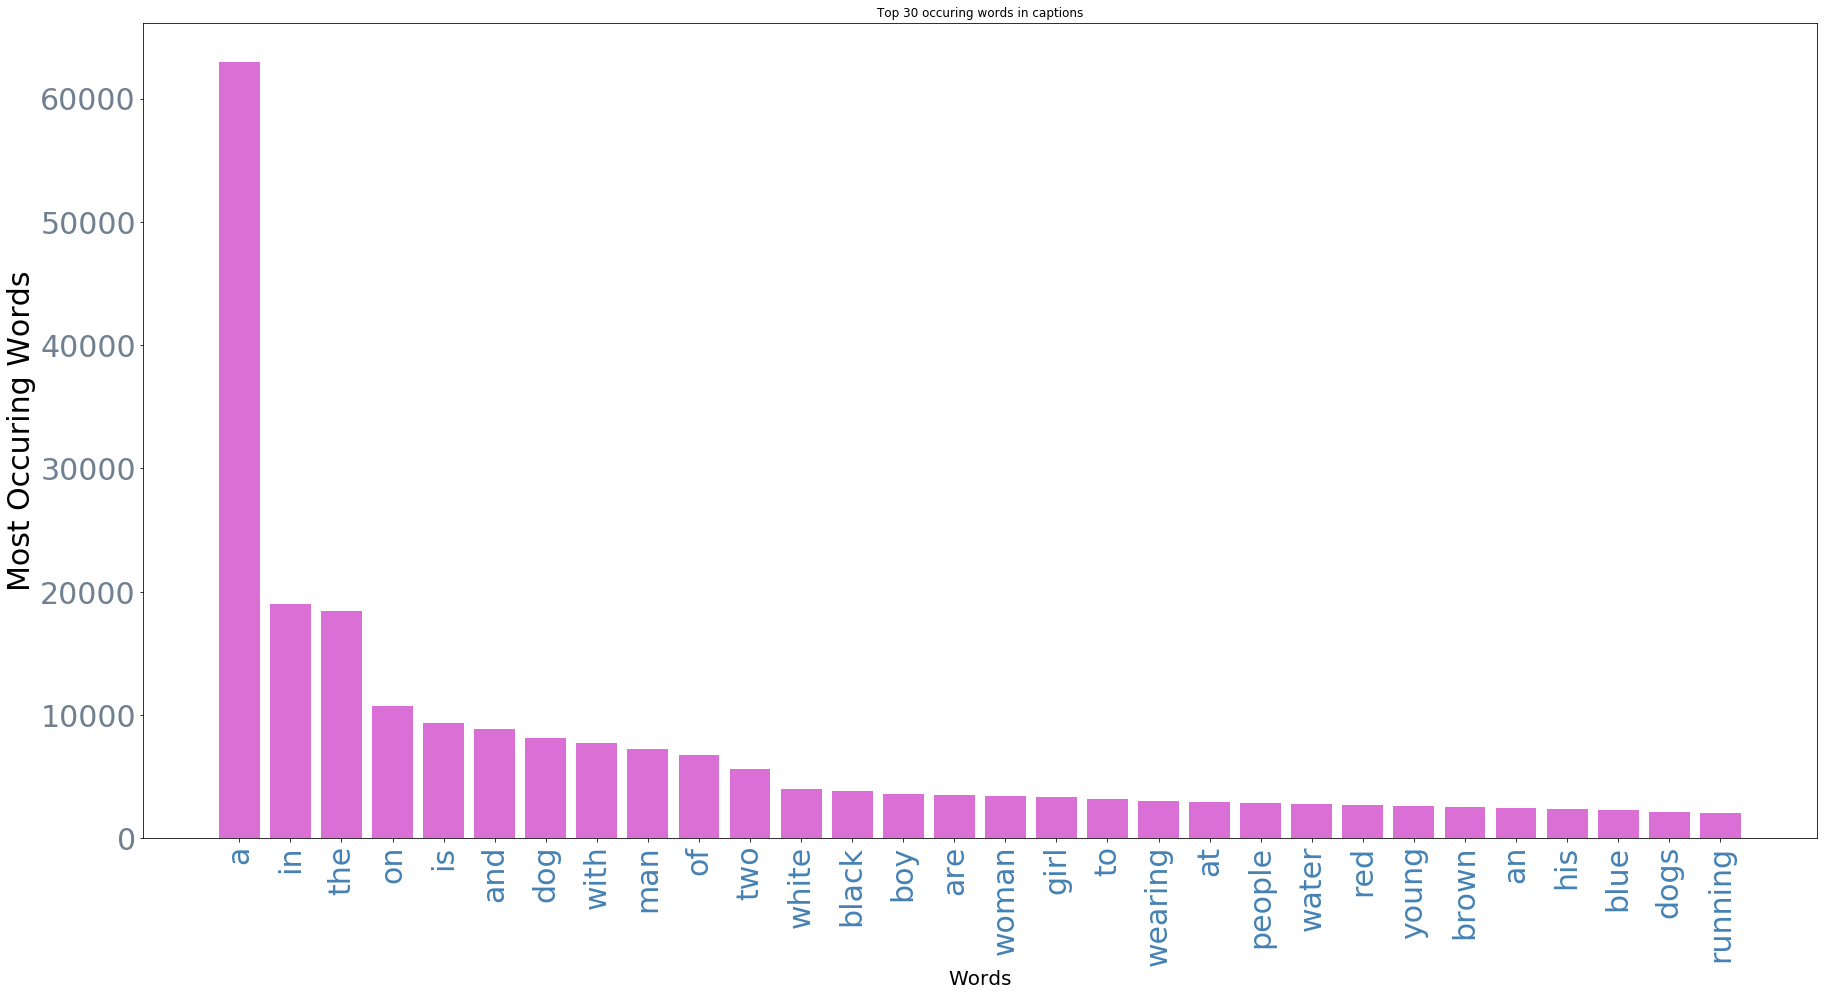

In [16]:
#Visualise the top 30 occuring words in the captions
#write your code here


def plotTopWords(words,count,title):
    plt.figure(figsize=(30,15))
    plt.bar(words,count,color='orchid')
    plt.xlabel("Words",fontsize=20)
    plt.ylabel("Most Occuring Words",fontsize=30)
    plt.xticks(words,rotation=90,fontsize=30,color='steelblue')
    plt.yticks(fontsize=30,color='slategrey')
    plt.title(title)
    plt.show()

words=list(word_count[:30].Word)
counts=list(word_count[:30].Count)
title='Top 30 occuring words in captions'
plotTopWords(words,counts,title)

In [17]:
#Create a list which contains all the captions
#add the <start> & <end> token to all those captions as well
df['Captions']=df['Captions'].apply(lambda x: "<start> " + x +" <end>")
annotations=df['Captions']


#Create a list which contains all the path to the images
all_img_path=df['Path']

print("Total captions present in the dataset: "+ str(len(annotations)))
print("Total images present in the dataset: " + str(len(all_img_path)))
print("Total Unique path present in the dataset: " + str(len(sorted(set(all_img_path)))))   ## Unique paths divided amont the entire dataset

Total captions present in the dataset: 40455
Total images present in the dataset: 40455
Total Unique path present in the dataset: 8091


In [18]:
df['Captions'].head()

0    <start> A child in a pink dress is climbing up a set of stairs in an entry way . <end>
1    <start> A girl going into a wooden building . <end>                                   
2    <start> A little girl climbing into a wooden playhouse . <end>                        
3    <start> A little girl climbing the stairs to her playhouse . <end>                    
4    <start> A little girl in a pink dress going into a wooden cabin . <end>               
Name: Captions, dtype: object

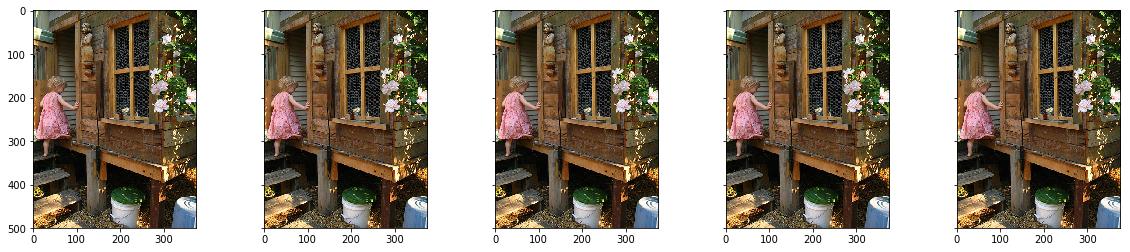

In [19]:
## Lets check the captions Images
show_image(df.Path[:5])


## Pre-Processing the captions
1.Create the tokenized vectors by tokenizing the captions fore ex :split them using spaces & other filters. 
This gives us a vocabulary of all of the unique words in the data. Keep the total vocaublary to top 5,000 words for saving memory.

2.Replace all other words with the unknown token "UNK" .

3.Create word-to-index and index-to-word mappings.

4.Pad all sequences to be the same length as the longest one.

In [20]:
# create the tokenizer

#your code here

top_vocab=5000

def tokenize_words(captions):
    tokenizer=tf.keras.preprocessing.text.Tokenizer(num_words=top_vocab,
                                                    filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n',
                                                    oov_token="UNK",
                                                    document_count=0)
    tokenizer.fit_on_texts(captions)
    # Adding PAD 
    tokenizer.word_index['PAD'] = 0
    tokenizer.index_word[0] = 'PAD'
    return tokenizer


    

In [21]:
annotations.head()

0    <start> A child in a pink dress is climbing up a set of stairs in an entry way . <end>
1    <start> A girl going into a wooden building . <end>                                   
2    <start> A little girl climbing into a wooden playhouse . <end>                        
3    <start> A little girl climbing the stairs to her playhouse . <end>                    
4    <start> A little girl in a pink dress going into a wooden cabin . <end>               
Name: Captions, dtype: object

In [22]:
all_img_path.head()

0    ./Flickr8K/Images/1000268201_693b08cb0e.jpg
1    ./Flickr8K/Images/1000268201_693b08cb0e.jpg
2    ./Flickr8K/Images/1000268201_693b08cb0e.jpg
3    ./Flickr8K/Images/1000268201_693b08cb0e.jpg
4    ./Flickr8K/Images/1000268201_693b08cb0e.jpg
Name: Path, dtype: object

In [27]:
img_captions=annotations
tokenizer = tokenize_words(img_captions)

In [28]:
# Create word-to-index and index-to-word mappings.

#your code here

def print_word_to_index(word):
    print("Word = {}, index = {}".format(word, tokenizer.word_index[word]))

          
print("Word to index mapping")
print_word_to_index("cat")  # Checking index of word cat
print_word_to_index("bicycle") # Checking index of word bicycle
print_word_to_index("<start>")

Word to index mapping
Word = cat, index = 591
Word = bicycle, index = 145
Word = <start>, index = 3


In [29]:
def print_index_to_word(index):
    print("Index = {}, Word = {}".format(index, tokenizer.index_word[index]))

          
print("Index to word mapping")
print_index_to_word(5)
print_index_to_word(4999)

Index to word mapping
Index = 5, Word = in
Index = 4999, Word = nadal


In [30]:
caption_sequence = tokenizer.texts_to_sequences(img_captions)
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(caption_sequence, padding='post')

print("The shape of Caption vector is :" + str(cap_vector.shape))
print(cap_vector[:5])



The shape of Caption vector is :(40455, 39)
[[   3    2   44    5    2   91  173    8  120   52    2  394   13  395
     5   29    1  671    4    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]
 [   3    2   20  317   65    2  197  118    4    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]
 [   3    2   41   20  120   65    2  197 2438    4    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]
 [   3    2   41   20  120    6  395   21   61 2438    4    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]
 [   3    2   41   20    5    2   91  173  317   65    2  197 2982    4
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
    

In [31]:
max_length = max([len(cap) for cap in caption_sequence])
print("Shape of caption vector :", cap_vector.shape)
print("Maximium length of sequence = ", max_length)

Shape of caption vector : (40455, 39)
Maximium length of sequence =  39


In [32]:
# Create a word count of your tokenizer to visulize the Top 30 occuring words after text processing

count_word=tokenizer.word_counts
count_word=sorted(count_word.items(),reverse=True , key=operator.itemgetter(1))   ### Return a callable object that fetches item from its operand using the operand’s __getitem__() method. 
count_word[:30]

[('a', 62992),
 ('<start>', 40455),
 ('<end>', 40455),
 ('in', 18986),
 ('the', 18419),
 ('on', 10745),
 ('is', 9345),
 ('and', 8862),
 ('dog', 8138),
 ('with', 7765),
 ('man', 7274),
 ('of', 6723),
 ('two', 5642),
 ('white', 3959),
 ('black', 3848),
 ('boy', 3581),
 ('are', 3504),
 ('woman', 3402),
 ('girl', 3328),
 ('to', 3176),
 ('wearing', 3062),
 ('at', 2915),
 ('people', 2883),
 ('water', 2790),
 ('red', 2691),
 ('young', 2630),
 ('brown', 2578),
 ('an', 2432),
 ('his', 2357),
 ('blue', 2279)]

## Pre-processing the images

1.Resize them into the shape of (299, 299)

3.Normalize the image within the range of -1 to 1, such that it is in correct format for InceptionV3. 

In [33]:
#write your code here

shape=(299,299)

def resize_image(path):
    images=tf.io.read_file(path)
    decodedImages=tf.image.decode_jpeg(images)  ##  Decode a JPEG-encoded image to a uint8 tensor.
    resized_image=tf.image.resize(decodedImages,shape)
    converted_image=tf.keras.applications.inception_v3.preprocess_input(resized_image)  ## tensorflow.org/api_docs/python/tf/keras/applications/inception_v3/InceptionV3
    return converted_image,path

In [34]:
encode = sorted(set(all_img_vector))
image_dataset = tf.data.Dataset.from_tensor_slices(encode) ## https://www.geeksforgeeks.org/tensorflow-tf-data-dataset-from_tensor_slices/
image_dataset = image_dataset.map(resize_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(64)  ##https://www.tensorflow.org/versions/r2.3/api_docs/python/tf/data/experimental#other_members
print(image_dataset)

<BatchDataset shapes: ((None, 299, 299, None), (None,)), types: (tf.float32, tf.string)>


## Create the train & test data 
1.Combine both images & captions to create the train & test dataset using tf.data.Dataset API. Create the train-test spliit using 80-20 ratio & random state = 42

2.Make sure you have done Shuffle and batch while building the dataset

3.The shape of each image in the dataset after building should be (batch_size, 299, 299, 3)

4.The shape of each caption in the dataset after building should be(batch_size, max_len)


In [35]:
#write your code here

img_train,img_test,cap_train,cap_test=train_test_split(all_img_vector,cap_vector,test_size=0.2,random_state=42,shuffle=False)

In [36]:
## We need to delete the previous images for reruning this model , and remove extra images for model training

output_imgs = glob.glob(output_images + '*.*')
print("The total image present in the dataset: {}".format(len(output_imgs)))
if len(output_imgs)>0:
    for pathX in (output_imgs):
        os.remove(pathX)
output_imgs_npy=glob.glob(output_images + '*.npy')
print("The total images after deleting : {}".format(len(output_imgs_npy)))

The total image present in the dataset: 8091
The total images after deleting : 0


In [37]:
sample_img_batch, sample_cap_batch = next(iter(image_dataset))
print(sample_img_batch.shape) #(batch_size, 299, 299, 3)
print(sample_cap_batch.shape) #(batch_size, max_len)

(64, 299, 299, 3)
(64,)


## Load the pretrained Imagenet weights of Inception net V3

1.To save the memory(RAM) from getting exhausted, extract the features of thei mage using the last layer of pre-trained model. Including this as part of training will lead to higher computational time.

2.The shape of the output of this layer is 8x8x2048. 

3.Use a function to extract the features of each image in the train & test dataset such that the shape of each image should be (batch_size, 8*8, 2048)



In [38]:
## https://www.tensorflow.org/tutorials/text/image_captioning#initialize_inceptionv3_and_load_the_pretrained_imagenet_weights

image_model = tf.keras.applications.InceptionV3(include_top=False,weights='imagenet')

new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

In [39]:
# write your code to extract features from each image in the dataset

## tqdm - Instantly make your loops show a smart progress meter


try:
    os.mkdir("Images")
except FileExistsError:
    # directory already exists
    pass


# os.mkdir('Images')
all_images_npy=[]

for img,path in tqdm(image_dataset):
    batch_features=image_features_extract_model(img)
    batch_features=tf.reshape(batch_features,(batch_features.shape[0], -1, batch_features.shape[3]))
    
    ## Saving into .npy extesion  :--   https://towardsdatascience.com/what-is-npy-files-and-why-you-should-use-them-603373c78883
    for batchFeature,p in zip(batch_features,path):
        file_name = p.numpy().decode("utf-8").split('/')[-1]
        all_images_npy.append(file_name)
        np.save(output_images +file_name, batchFeature.numpy())

127it [01:02,  1.45it/s]


In [40]:
print("The total images present in the dataset: {}".format(len(all_images_npy)))
print(all_images_npy[0])

The total images present in the dataset: 8091
1000268201_693b08cb0e.jpg


In [41]:
img_to_cap_vector = collections.defaultdict(list)

for img,cap in zip(all_img_vector,cap_vector):
    img_to_cap_vector[img].append(cap)



In [42]:
## Performing this task :-    Make sure you have done Shuffle and batch while building the dataset

## Setting random itenration globally 
tf.random.set_seed(42)


## Fetching keys of captions vectors
img_keys=list(img_to_cap_vector.keys())
## Shuffling those keys 42 times as mentioned above
random.shuffle(img_keys)

## Dividing the data in to 80-20 ratio 
train_test_slice_index=int(len(img_keys)*0.8)
image_name_train_keys,image_name_val_keys=img_keys[:train_test_slice_index],img_keys[train_test_slice_index:]



## Below code is  meant for feeding the particular image according to our shuffled keys, 
## hence we get shuffled dataset
## Logic here was to shuffle the keys only , instead of entire dataset and then feed the 
## images to respected keys 


image_train_set=[]
captions_train_set=[]

for x in image_name_train_keys:
    cap_len=len(img_to_cap_vector[x])
    image_train_set.extend([x] * cap_len)
    captions_train_set.extend(img_to_cap_vector[x])

image_test_set=[]
captions_test_set=[]

for y in image_name_val_keys:
    cap_len=len(img_to_cap_vector[y])
    image_test_set.extend([y] * cap_len)
    captions_test_set.extend(img_to_cap_vector[y])



In [43]:
## Let's check the size of our dateset size

print("Image_train = {}, Captions_train = {}".format(len(image_train_set), len(captions_train_set)))
print("Image_test = {}, Captions_test = {}".format(len(image_test_set), len(captions_test_set)))

Image_train = 32360, Captions_train = 32360
Image_test = 8095, Captions_test = 8095


In [44]:
def vector_to_sentences(captions_listing):
    caption_words=[]
    for cap in captions_listing:
        list_of_captions=list(cap)
        caption_words.append(' '.join(tokenizer.index_word[i] for i in list_of_captions))
    return caption_words

In [45]:
caption_words=vector_to_sentences(list(captions_train_set[:30]))
print(caption_words[18:20])



['<start> a large sleek brown dog is standing in the water <end> PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD', '<start> the large brown dog is walking into a shallow lake <end> PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD']


./Flickr8K/Images/2855727603_e917ded363.jpg
./Flickr8K/Images/2855727603_e917ded363.jpg


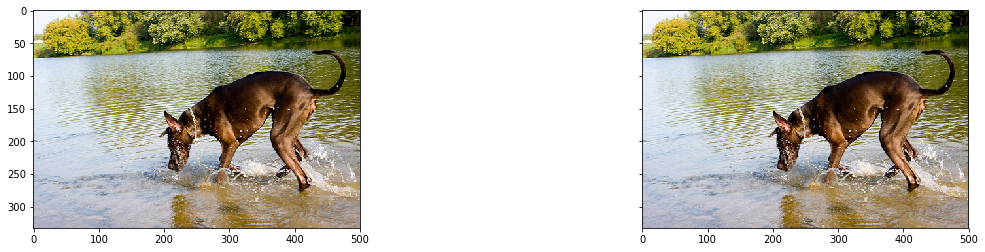

In [46]:
filename = (image_path + image_train_set[18].split('/')[-1]).replace(".npy","")
filename1 = (image_path + image_train_set[19].split('/')[-1]).replace(".npy","")

show_image([filename,filename1])

print(filename)
print(filename1)

    ~ Looks Like the captions and image's index are related , We can train our model now

In [47]:
def parrallel_func_map(image_name,captions):
    file_name=output_images+image_name.decode('utf-8').split('/')[-1] + ".npy"
    image_tensor=np.load(file_name)
    return image_tensor,captions

In [48]:

batch_size=64
buffer_sizes=1000
train_dataset = tf.data.Dataset.from_tensor_slices((image_train_set, captions_train_set))

train_dataset = train_dataset.map(lambda item1, item2: tf.numpy_function(
          parrallel_func_map, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)


# Shuffle and batching
train_dataset = train_dataset.shuffle(buffer_sizes).batch(batch_size)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [49]:


test_dataset = tf.data.Dataset.from_tensor_slices((image_test_set, captions_test_set))
# Use map to load the numpy files in parallel
test_dataset = test_dataset.map(lambda item1, item2: tf.numpy_function(
          parrallel_func_map, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Shuffle and batch
test_dataset = test_dataset.batch(buffer_sizes).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [50]:
sample_img_batch, sample_cap_batch = next(iter(train_dataset))
print(sample_img_batch.shape)  #(batch_size, 8*8, 2048)
print(sample_cap_batch.shape) #(batch_size,40)

(64, 64, 2048)
(64, 39)


## Model Building
1.Set the parameters

2.Build the Encoder, Attention model & Decoder

In [51]:
from tensorflow.keras import activations

In [52]:
features_shape = 2048
attention_features_shape = 64
embedding_dim = 256 
units = 512
vocab_size =top_vocab+1 #top 5,000 words +1
train_num_steps = len(image_train_set) // batch_size    
test_num_steps = len(image_test_set) // batch_size   

### Encoder

In [53]:
class Encoder(Model):
    def __init__(self,embed_dim):
        super(Encoder, self).__init__()
        self.dense = tf.keras.layers.Dense(embedding_dim, activation=activations.relu)
        
    def call(self, features):
        features =  self.dense(features)# extract the features from the image shape: (batch, 8*8, embed_dim)
        features = tf.nn.relu(features)

        return features

In [54]:
encoder=Encoder(embedding_dim)


### Attention model

In [55]:
class Attention_model(Model):
    def __init__(self, units):
        super(Attention_model, self).__init__()
        self.W1 =  tf.keras.layers.Dense(units)#build your Dense layer
        self.W2 = tf.keras.layers.Dense(units) #build your Dense layer
        self.V =  tf.keras.layers.Dense(1) #build your final Dense layer with unit 1
        self.units=units

    def call(self, features, hidden):
        #features shape: (batch_size, 8*8, embedding_dim)
        # hidden shape: (batch_size, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden,1) # Expand the hidden shape to shape: (batch_size, 1, hidden_size)
        attention_hidden_layer = (tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis)))
        score = self.V(attention_hidden_layer)   # build your score funciton to shape: (batch_size, 8*8, units)
        attention_weights = tf.nn.softmax(score,axis=1)  # extract your attention weights with shape: (batch_size, 8*8, 1)
        context_vector = attention_weights * features  #shape: create the context vector with shape (batch_size, 8*8,embedding_dim)
        context_vector = tf.reduce_sum(context_vector,axis=1) # reduce the shape to (batch_size, embedding_dim)
        

        return context_vector, attention_weights

### Decoder

In [56]:
class Decoder(Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units=units
        self.attention = Attention_model(self.units)
        self.embed = tf.keras.layers.Embedding(vocab_size,embed_dim)
        self.gru = tf.keras.layers.GRU(self.units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform')
        self.d1 = tf.keras.layers.Dense(self.units)   #build your Dense layer
        self.d2 = tf.keras.layers.Dense(vocab_size) #build your Dense layer
        

    def call(self,x,features, hidden):
        context_vector, attention_weights = self.attention(features,hidden)#create your context vector & attention weights from attention model
        embed = self.embed(x)# embed your input to shape: (batch_size, 1, embedding_dim)
        embed = tf.concat([tf.expand_dims(context_vector,1),embed],axis=-1)  # Concatenate your input with the context vector from attention layer. Shape: (batch_size, 1, embedding_dim + embedding_dim)
        output,state = self.gru(embed) # Extract the output & hidden state from GRU layer. Output shape : (batch_size, max_length, hidden_size)
        output = self.d1(output)
        output = tf.reshape(output, (-1, output.shape[2])) # shape : (batch_size * max_length, hidden_size)
        output = self.d2(output) # shape : (batch_size * max_length, vocab_size)
        
        return output,state, attention_weights
    
    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [57]:
decoder=Decoder(embedding_dim, units, vocab_size)

In [58]:
features=encoder(sample_img_batch)

hidden = decoder.init_state(batch_size=sample_cap_batch.shape[0])
dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * sample_cap_batch.shape[0], 1)

predictions, hidden_out, attention_weights= decoder(dec_input, features, hidden)
print('Feature shape from Encoder: {}'.format(features.shape)) #(batch, 8*8, embed_dim)
print('Predcitions shape from Decoder: {}'.format(predictions.shape)) #(batch,vocab_size)
print('Attention weights shape from Decoder: {}'.format(attention_weights.shape)) #(batch, 8*8, embed_dim)

Feature shape from Encoder: (64, 64, 256)
Predcitions shape from Decoder: (64, 5001)
Attention weights shape from Decoder: (64, 64, 1)


## Model training & optimization
1.Set the optimizer & loss object

2.Create your checkpoint path

3.Create your training & testing step functions

4.Create your loss function for the test dataset

In [59]:
optimizer = tf.keras.optimizers.Adam() #define the optimizer
loss_object =  tf.keras.losses.SparseCategoricalCrossentropy(from_logits= True, reduction='none') #define your loss object
metric = tf.keras.metrics.Mean('train_loss',dtype=tf.float32)

In [60]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [61]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [62]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

In [63]:
@tf.function
def train_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    
    with tf.GradientTape() as tape:
        #write your code here to do the training steps
        
        features=encoder(img_tensor,training=True)
        
        for i in range(1,target.shape[1]):
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], predictions)
            dec_input = tf.expand_dims(target[:, i], 1)
            
    avg_loss = (loss / int(target.shape[1]))

    trainable_variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, trainable_variables)

    optimizer.apply_gradients(zip(gradients, trainable_variables))
    metric(loss)
    return loss, avg_loss

In [64]:
@tf.function
def test_step(img_tensor, target):
    loss = 0
    
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    features = encoder(img_tensor)
    for i in range(1, target.shape[1]):
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], predictions)
            predicted_id = tf.argmax(predictions[0])
            dec_input = tf.expand_dims([predicted_id] * target.shape[0] , 1)
   
    avg_loss = (loss / int(target.shape[1]))
    return loss, avg_loss

In [65]:
def test_loss_cal(test_dataset):
    total_loss = 0

    #write your code to get the average loss result on your test data
    for (batch,(img_tensor,target)) in enumerate(test_dataset):
        batch_loss, t_loss = test_step(img_tensor, target)
        total_loss += t_loss
    
    return total_loss/int(target.shape[1])

In [66]:
train_loss = tf.keras.metrics.Mean('train_loss',dtype=tf.float32)

In [103]:
loss_plot = []
test_loss_plot = []
EPOCHS = 20

best_test_loss=100
for epoch in tqdm(range(0, EPOCHS)):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        avg_train_loss=total_loss / train_num_steps
        
    loss_plot.append(avg_train_loss)    
    test_loss = test_loss_cal(test_dataset)
    test_loss_plot.append(test_loss)
    
    print ('For epoch: {}, the train loss is {:.3f}, & test loss is {:.3f}'.format(epoch+1,avg_train_loss,test_loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    
    if test_loss < best_test_loss:
        print('Test loss has been reduced from %.3f to %.3f' % (best_test_loss, test_loss))
        best_test_loss = test_loss
        ckpt_manager.save()

  0%|          | 0/20 [00:00<?, ?it/s]

For epoch: 1, the train loss is 0.443, & test loss is 0.610
Time taken for 1 epoch 310.8017313480377 sec

Test loss has been reduced from 100.000 to 0.610


 10%|█         | 2/20 [10:44<1:35:24, 318.02s/it]

For epoch: 2, the train loss is 0.422, & test loss is 0.634
Time taken for 1 epoch 333.28632712364197 sec



 15%|█▌        | 3/20 [16:03<1:30:10, 318.25s/it]

For epoch: 3, the train loss is 0.405, & test loss is 0.647
Time taken for 1 epoch 318.68182611465454 sec



 20%|██        | 4/20 [21:12<1:24:09, 315.59s/it]

For epoch: 4, the train loss is 0.390, & test loss is 0.658
Time taken for 1 epoch 309.3714556694031 sec



 25%|██▌       | 5/20 [25:27<1:14:21, 297.42s/it]

For epoch: 5, the train loss is 0.376, & test loss is 0.682
Time taken for 1 epoch 255.0180184841156 sec



 30%|███       | 6/20 [28:43<1:02:16, 266.87s/it]

For epoch: 6, the train loss is 0.361, & test loss is 0.672
Time taken for 1 epoch 195.56955647468567 sec



 35%|███▌      | 7/20 [33:06<57:33, 265.62s/it]  

For epoch: 7, the train loss is 0.349, & test loss is 0.695
Time taken for 1 epoch 262.6776444911957 sec



 40%|████      | 8/20 [37:10<51:52, 259.35s/it]

For epoch: 8, the train loss is 0.338, & test loss is 0.706
Time taken for 1 epoch 244.6908872127533 sec



 45%|████▌     | 9/20 [41:08<46:21, 252.87s/it]

For epoch: 9, the train loss is 0.328, & test loss is 0.725
Time taken for 1 epoch 237.70088934898376 sec



 50%|█████     | 10/20 [45:23<42:12, 253.30s/it]

For epoch: 10, the train loss is 0.316, & test loss is 0.754
Time taken for 1 epoch 254.23672914505005 sec



 55%|█████▌    | 11/20 [49:53<38:44, 258.33s/it]

For epoch: 11, the train loss is 0.308, & test loss is 0.743
Time taken for 1 epoch 270.030921459198 sec



 60%|██████    | 12/20 [54:35<35:23, 265.43s/it]

For epoch: 12, the train loss is 0.300, & test loss is 0.764
Time taken for 1 epoch 281.9653618335724 sec



 65%|██████▌   | 13/20 [59:12<31:23, 269.13s/it]

For epoch: 13, the train loss is 0.290, & test loss is 0.773
Time taken for 1 epoch 277.75624680519104 sec



 70%|███████   | 14/20 [1:03:52<27:13, 272.32s/it]

For epoch: 14, the train loss is 0.285, & test loss is 0.799
Time taken for 1 epoch 279.7269642353058 sec



 75%|███████▌  | 15/20 [1:06:46<20:14, 242.89s/it]

For epoch: 15, the train loss is 0.277, & test loss is 0.796
Time taken for 1 epoch 174.2101535797119 sec



 80%|████████  | 16/20 [1:11:26<16:55, 253.85s/it]

For epoch: 16, the train loss is 0.273, & test loss is 0.811
Time taken for 1 epoch 279.40876603126526 sec



 85%|████████▌ | 17/20 [1:16:00<12:59, 259.97s/it]

For epoch: 17, the train loss is 0.267, & test loss is 0.827
Time taken for 1 epoch 274.24706840515137 sec



 90%|█████████ | 18/20 [1:20:41<08:52, 266.36s/it]

For epoch: 18, the train loss is 0.259, & test loss is 0.830
Time taken for 1 epoch 281.27347469329834 sec



 95%|█████████▌| 19/20 [1:25:43<04:36, 276.86s/it]

For epoch: 19, the train loss is 0.255, & test loss is 0.841
Time taken for 1 epoch 301.36723709106445 sec



100%|██████████| 20/20 [1:30:39<00:00, 282.66s/it]

For epoch: 20, the train loss is 0.251, & test loss is 0.847
Time taken for 1 epoch 296.143084526062 sec



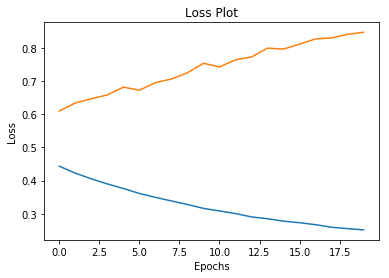

In [104]:
plt.plot(loss_plot)
plt.plot(test_loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

## Model Evaluation
1.Define your evaluation function using greedy search

2.Define your evaluation function using beam search ( optional)

3.Test it on a sample data using BLEU score

### Greedy Search

In [105]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(resize_image(image)[0], 0) 
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val) 

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input,features,hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy() 
        result.append(tokenizer.index_word[predicted_id])
        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot,predictions

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot,predictions


In [106]:
def plot_attmap(caption, weights, image):

    fig = plt.figure(figsize=(10, 10))
    temp_img = np.array(Image.open(image))
    
    len_cap = len(caption)
    for cap in range(len_cap):
        weights_img = np.reshape(weights[cap], (8,8))
        weights_img = np.array(Image.fromarray(weights_img).resize((224, 224), Image.LANCZOS))
        
        ax = fig.add_subplot(len_cap//2, len_cap//2, cap+1)
        ax.set_title(caption[cap], fontsize=15)
        
        img=ax.imshow(temp_img)
        
        ax.imshow(weights_img, cmap='gist_heat', alpha=0.6,extent=img.get_extent())
        ax.axis('off')
    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.show()

In [107]:
from nltk.translate.bleu_score import sentence_bleu


In [108]:
def filt_text(text):
    filt=['<start>','<unk>','<end>'] 
    temp= text.split()
    [temp.remove(j) for k in filt for j in temp if k==j]
    text=' '.join(temp)
    return text

In [138]:
# Let's check our model

rid = np.random.randint(0, len(image_test_set))
image = image_test_set[rid]

image = image_path +(image.split('/')[-1]).replace(".npy","")
print(image)
real_caption = ' '.join([tokenizer.index_word[i] for i in captions_test_set[rid] if i not in [0]])
result, weight,predictions = evaluate(image)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))

./Flickr8K/Images/504385521_6e668691a3.jpg
Real Caption: <start> a big dog shakes itself dry while standing in a creek <end>
Prediction Caption: a wet dog splashes water 's face <end>


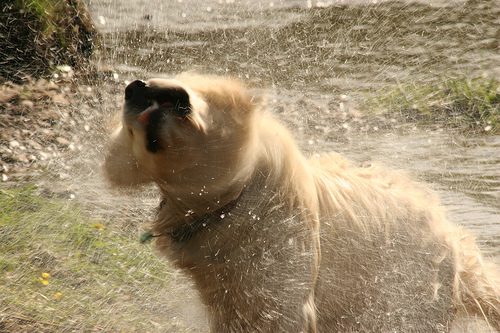

In [139]:
Image.open(image)

    ~ Above prediction is very good,
    Looks Like Our model is acquiring features and recognizing it as it should be

./Flickr8K/Images/3515665835_22e6fb1193.jpg
BELU score: 2.2250738585072627e-306
Real Caption: a man performs a dirt bike stunt over the sand
Prediction Caption: mountain biker doing a trick on a track with graffiti as others run and doing tricks on a bike doing tricks


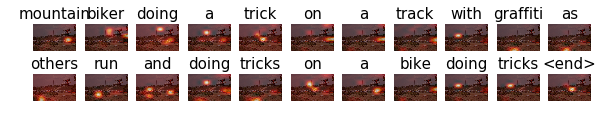

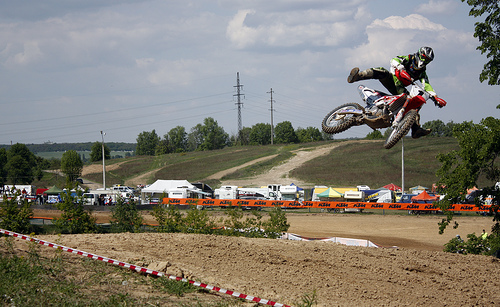

In [130]:
## Finalizing the model

rid = np.random.randint(0, len(img_test))
test_image = image_test_set[rid]
print(test_image)
# test_image = './Flickr8K/Images/404702274_fa8b3fe378.jpg'
# real_caption = '<start> black dog is digging in the snow <end>'

real_caption = ' '.join([tokenizer.index_word[i] for i in captions_test_set[rid] if i not in [0]])
result, attention_plot,pred_test = evaluate(test_image)


real_caption=filt_text(real_caption)      


pred_caption=' '.join(result).rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = pred_caption.split()

score = sentence_bleu(reference, candidate, weights=(0,0,1,0))
print ('BELU score: {}'.format(score*100))
print ('Real Caption:', real_caption)
print ('Prediction Caption:', pred_caption)
plot_attmap(result, attention_plot, test_image)


Image.open(test_image)

In [175]:
captions=evaluate(test_image)


In [176]:
## Finalizing Caption

final_caption=' '.join(captions[0])

print(final_caption)

a bike rider jumps with other hand jump with a dirt bike is doing tricks on a motorcycle gives high jump <end>


     Project Done By :- 
                        
                        
                        Sagar Pawar

    ## Need Guidance from Reveiwer, Please answer the question below 

Since this project was already provided with starter code to kickstart and save our time.
This sample code gave a general idea what I've been doing so far and what will be the upcoming next step, I followed through all it 

However we won't be provided starter code in real time projects and problems, As a developer I understand that to achieve one solution we have steps i.e Algorithms for some "x" problem , 

We can say that we need to follow "y" algorithm for "x" problem, correct


My question is How can I achieve same thing in this field, how can I bifurcate the paths for debugging in this field 

I know we need Data,then clean the data, then train the model etc etc. 
these are generic basic steps , but with various problems needs various tricks, how can i know which to use when 
and how can I learn them and from where I can take reference to ?? 
is it by reading articles ? Checking someone else's code ? or will it come by experiance ?

A Reference would be suffice for my queries


If its possible please answer this in project review this will be great help and My apologies if it bothers you and any rule /protocols

Thank You 